# Part B

## Modelling over a mass distribution using IMF

In [1]:
%pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from subprocess import run
import os
import mesa_reader
import multiprocessing as mp

In [3]:

def salpeter_imf(mass_min, mass_max, num_stars):
    """Generate masses following Salpeter IMF: dN/dM ∝ M^(-2.35)"""
    alpha = -2.35
    u = np.random.random(num_stars)
    alpha1 = alpha + 1
    m1 = mass_min**alpha1
    m2 = mass_max**alpha1
    masses = (m1 + (m2 - m1)*u)**(1/alpha1)
    return masses

In [4]:
def inlist_pgstar(mass):
    return f"""
&pgstar
  ! see star/defaults/pgstar.defaults

  ! MESA uses PGPLOT for live plotting and gives the user a tremendous
  ! amount of control of the presentation of the information.

  ! show HR diagram
  ! this plots the history of L,Teff over many timesteps

    TRho_Profile_win_width = 6
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_win_flag = .true.
    TRho_Profile_file_flag = .true.
    TRho_Profile_file_dir = 'pgstar_out_{mass}'
    TRho_Profile_file_prefix = 'trho_pgstar_{mass}'
    TRho_Profile_file_interval = 50
    TRho_Profile_win_width = 9
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_title = 'TRho'


  ! set static plot bounds
    HR_logT_min = 3.5
    HR_logT_max = 4.6
    HR_logL_min = 2.0
    HR_logL_max = 6.0

  ! set window size (aspect_ratio = height/width)
    HR_win_width = 6
    HR_win_aspect_ratio = 1.0
    HR_win_flag = .true.
    HR_file_flag = .true.
    HR_file_dir = 'pgstar_out_{mass}'
    HR_file_prefix = 'hr_pgstar_{mass}'
    HR_file_interval = 50
    HR_win_width = 9
    HR_win_aspect_ratio = 1.0
    HR_title = 'HR'



  ! show temperature/density profile
  ! this plots the internal structure at single timestep
    TRho_Profile_win_flag = .true.

  ! add legend explaining colors
    show_TRho_Profile_legend = .true.

  ! display numerical info about the star
    show_TRho_Profile_text_info = .true.

  ! set window size (aspect_ratio = height/width)
    TRho_Profile_win_width = 8
    TRho_Profile_win_aspect_ratio = 0.75

/ ! end of pgstar namelist
"""


def inlist_project(mass):
    return f"""
&star_job

    create_pre_main_sequence_model = .true.

    save_model_when_terminate = .false.
    save_model_filename = '15M_at_TAMS.mod'

    pgstar_flag = .true.

/ 


&kap
  use_Type2_opacities = .true.
  Zbase = 0.02

/

&controls
    initial_mass = {mass} ! in Msun units
    initial_z = 0.02

    Lnuc_div_L_zams_limit = 0.99d0
    stop_near_zams = .true.

    xa_central_lower_limit_species(1) = 'h1'
    xa_central_lower_limit(1) = 1d-3

     energy_eqn_option = 'dedt'
     use_gold_tolerances = .true.


/
"""

In [5]:
mass_l_t = dict()
results = []

def run_mesa_model(masses):
    for mass in masses:
        """Run MESA for a single mass"""
        print(f"FOR MASS: {mass}")
        
        with open('star/inlist_pgstar', 'w') as f:
            f.write(inlist_pgstar(mass))
        
        with open('star/inlist_project', 'w') as f:
            f.write(inlist_project(mass))
        
        # run(['cd star'], check=True)
        run(['pwd'], check=True)
        run(['ls'], check=True)
        os.chdir("./star")
        run(['pwd'], check=True)
        run(['./mk'], check=True)
        run(['./rn'], check=True)
        os.chdir("../")
        
        if os.path.exists('star/LOGS/history.data'):
            results.append({'mass': mass, 'success': True})
        else:
            results.append({'mass': mass, 'success': False})

        mr = mesa_reader.MesaData(file_name='./star/LOGS/history.data')
        mass_l_t[mass] = (mr.log_L, mr.log_Teff)



  

In [6]:
def plot_hr_diagram(masses):
    """Plot HR diagram for all stars in the same plot"""
    plt.figure()
    for mass in masses:
        plt.plot(mass_l_t[mass][1], mass_l_t[mass][0], label=f'{mass:.2f} Msun')
    plt.gca().invert_xaxis()
    plt.xlabel('log(Teff)')
    plt.ylabel('log(L)')
    plt.legend()
    plt.show()

/root
/root/astrolab
FOR MASS: 1.3585926125743777
/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:00:00
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.595873   4737.327  -5.320353  -5.320353   1.358593   1.358593   0.700000   0.001010   0.280000  -4.765668    688      0
-4.8416E+00   6.595873   0.425935 -99.000000  -6.718167 -99.000000   0.000000   0.280000   0.009381   0.020000   0.058636      2
 3.6400E-05  -0.198865   0.508696 -99.000000 -99.000000  -7.022923   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.595873   4737.316  -5.320353  -5.320353   1.358593   1.358593   0.700000   0.001010   0.280000  -4.765668    688      0
-4.7625E+00   6.595873   0.425935 -99.000000  -6.718167 -99.000000   0.000000   0.280000   0.009381   0.020000   0.058636      2
 5.3680E-05  -0.198865   0.508692 -99.000000 -99.000000  -7.022921   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.595873   4737.308  -5.320353  -5.320353   1.358593   1.358593   0.700000   0.001010   0.280000  -4.765668    688      0
-4.6833E+00   6.595873   0.425935 -99.000000  -6.718167 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:06:15
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.268548   4835.570  -9.278722  -9.278722   3.644373   3.644373   0.700000   0.001010   0.280000  -7.829186    604      0
-4.8416E+00   6.268548   1.181323 -99.000000 -10.676589 -99.000000   0.000000   0.280000   0.009381   0.020000   0.030811      2
 3.6400E-05  -2.019235   2.055131 -99.000000 -99.000000  -7.626470   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.268548   4835.537  -9.278722  -9.278722   3.644373   3.644373   0.700000   0.001010   0.280000  -7.829186    604      0
-4.7625E+00   6.268548   1.181323 -99.000000 -10.676589 -99.000000   0.000000   0.280000   0.009381   0.020000   0.030811      2
 5.3680E-05  -2.019235   2.055119 -99.000000 -99.000000  -7.626467   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.268548   4835.504  -9.278722  -9.278722   3.644373   3.644373   0.700000   0.001010   0.280000  -7.829186    604      0
-4.6833E+00   6.268548   1.181323 -99.000000 -10.676589 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:10:40
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.590586   4660.190  -5.350856  -5.350856   1.248957   1.248957   0.700000   0.001010   0.280000  -4.632752    686      0
-4.8416E+00   6.590586   0.396502 -99.000000  -6.748663 -99.000000   0.000000   0.280000   0.009381   0.020000   0.061658      2
 3.6400E-05  -0.149252   0.421311 -20.594978 -99.000000  -6.996136   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.590586   4660.190  -5.350856  -5.350856   1.248957   1.248957   0.700000   0.001010   0.280000  -4.632752    686      0
-4.7625E+00   6.590586   0.396502 -99.000000  -6.748663 -99.000000   0.000000   0.280000   0.009381   0.020000   0.061658      2
 5.3680E-05  -0.149252   0.421312 -20.771070 -99.000000  -6.996136   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.590586   4660.190  -5.350856  -5.350856   1.248957   1.248957   0.700000   0.001010   0.280000  -4.632752    686      0
-4.6833E+00   6.590586   0.396502 -99.000000  -6.748663 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:14:25
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.373027   4935.521  -8.005750  -8.005750   3.070342   3.070342   0.700000   0.001010   0.280000  -7.139472    629      0
-4.8416E+00   6.373027   1.002500 -99.000000  -9.403615 -99.000000   0.000000   0.280000   0.009381   0.020000   0.034379      2
 3.6400E-05  -1.563035   1.733025 -99.000000 -99.000000  -7.484531   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.373027   4935.518  -8.005750  -8.005750   3.070342   3.070342   0.700000   0.001010   0.280000  -7.139472    629      0
-4.7625E+00   6.373027   1.002500 -99.000000  -9.403615 -99.000000   0.000000   0.280000   0.009381   0.020000   0.034379      2
 5.3680E-05  -1.563035   1.733024 -23.781370 -99.000000  -7.484531   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.373027   4935.511  -8.005750  -8.005750   3.070342   3.070342   0.700000   0.001010   0.280000  -7.139472    629      0
-4.6833E+00   6.373027   1.002499 -99.000000  -9.403615 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:20:23
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.608499   4415.126  -5.083256  -5.083256   1.014773   1.014773   0.700000   0.001010   0.280000  -4.157375    697      0
-4.8416E+00   6.608499   0.288404 -99.000000  -6.481021 -99.000000   0.000000   0.280000   0.009381   0.020000   0.070723      2
 3.6400E-05   0.083191   0.111274 -20.470040 -99.000000  -6.852239   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.608499   4415.128  -5.083256  -5.083256   1.014773   1.014773   0.700000   0.001010   0.280000  -4.157375    697      0
-4.7625E+00   6.608499   0.288404 -99.000000  -6.481021 -99.000000   0.000000   0.280000   0.009381   0.020000   0.070723      2
 5.3680E-05   0.083191   0.111275 -99.000000 -99.000000  -6.852239   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.608499   4415.129  -5.083256  -5.083256   1.014773   1.014773   0.700000   0.001010   0.280000  -4.157375    697      0
-4.6833E+00   6.608499   0.288404 -99.000000  -6.481021 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:25:38
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.593946   4700.680  -5.328776  -5.328776   1.303918   1.303918   0.700000   0.001010   0.280000  -4.698795    693      0
-4.8416E+00   6.593946   0.410908 -99.000000  -6.726587 -99.000000   0.000000   0.280000   0.009381   0.020000   0.060087      2
 3.6400E-05  -0.172801   0.465152 -99.000000 -99.000000  -7.009569   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.593946   4700.668  -5.328776  -5.328776   1.303918   1.303918   0.700000   0.001010   0.280000  -4.698795    693      0
-4.7625E+00   6.593946   0.410908 -99.000000  -6.726587 -99.000000   0.000000   0.280000   0.009381   0.020000   0.060087      2
 5.3680E-05  -0.172801   0.465148 -99.000000 -99.000000  -7.009567   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.593946   4700.656  -5.328776  -5.328776   1.303918   1.303918   0.700000   0.001010   0.280000  -4.698795    693      0
-4.6833E+00   6.593946   0.410908 -99.000000  -6.726587 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:31:05
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.580446   4742.619  -5.489702  -5.489702   1.365911   1.365911   0.700000   0.001010   0.280000  -4.844900    688      0
-4.8416E+00   6.580446   0.445415 -99.000000  -6.887522 -99.000000   0.000000   0.280000   0.009381   0.020000   0.058135      2
 3.6400E-05  -0.256326   0.549597 -99.000000 -99.000000  -7.044207   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.580446   4742.619  -5.489702  -5.489702   1.365911   1.365911   0.700000   0.001010   0.280000  -4.844900    688      0
-4.7625E+00   6.580446   0.445415 -99.000000  -6.887522 -99.000000   0.000000   0.280000   0.009381   0.020000   0.058135      2
 5.3680E-05  -0.256326   0.549597 -99.000000 -99.000000  -7.044207   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.580446   4742.619  -5.489702  -5.489702   1.365911   1.365911   0.700000   0.001010   0.280000  -4.844900    688      0
-4.6833E+00   6.580446   0.445415 -99.000000  -6.887522 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:34:37
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.569906   4826.989  -5.637854  -5.637854   1.525582   1.525582   0.700000   0.001010   0.280000  -5.095802    684      0
-4.8416E+00   6.569906   0.503352 -99.000000  -7.035685 -99.000000   0.000000   0.280000   0.009381   0.020000   0.054134      2
 3.6400E-05  -0.380850   0.696102 -99.000000 -99.000000  -7.094859   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.569906   4826.981  -5.637854  -5.637854   1.525582   1.525582   0.700000   0.001010   0.280000  -5.095802    684      0
-4.7625E+00   6.569906   0.503352 -99.000000  -7.035685 -99.000000   0.000000   0.280000   0.009381   0.020000   0.054134      2
 5.3680E-05  -0.380850   0.696099 -99.000000 -99.000000  -7.094858   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.569906   4826.978  -5.637854  -5.637854   1.525582   1.525582   0.700000   0.001010   0.280000  -5.095802    684      0
-4.6833E+00   6.569906   0.503352 -99.000000  -7.035685 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:37:46
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.609582   4426.925  -5.075847  -5.075847   1.024665   1.024665   0.700000   0.001010   0.280000  -4.171460    703      0
-4.8416E+00   6.609582   0.291390 -99.000000  -6.473614 -99.000000   0.000000   0.280000   0.009381   0.020000   0.070306      2
 3.6400E-05   0.078732   0.121883 -20.771070 -99.000000  -6.857987   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.609582   4426.913  -5.075847  -5.075847   1.024665   1.024665   0.700000   0.001010   0.280000  -4.171460    703      0
-4.7625E+00   6.609582   0.291390 -99.000000  -6.473614 -99.000000   0.000000   0.280000   0.009381   0.020000   0.070306      2
 5.3680E-05   0.078732   0.121878 -99.000000 -99.000000  -6.857982   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.609582   4426.899  -5.075847  -5.075847   1.024665   1.024665   0.700000   0.001010   0.280000  -4.171460    703      0
-4.6833E+00   6.609582   0.291390 -99.000000  -6.473614 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-03-03
TIME: 22:40:49
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.233307   4796.519  -9.724226  -9.724226   3.855035   3.855035   0.700000   0.001010   0.280000  -8.057827    599      0
-4.8416E+00   6.233307   1.240877 -99.000000 -11.122093 -99.000000   0.000000   0.280000   0.009381   0.020000   0.029732      2
 3.6400E-05  -2.171376   2.160152 -99.000000 -99.000000  -7.674045   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.233307   4796.521  -9.724226  -9.724226   3.855035   3.855035   0.700000   0.001010   0.280000  -8.057827    599      0
-4.7625E+00   6.233307   1.240877 -99.000000 -11.122093 -99.000000   0.000000   0.280000   0.009381   0.020000   0.029732      2
 5.3680E-05  -2.171376   2.160153 -99.000000 -99.000000  -7.674045   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.233307   4796.508  -9.724226  -9.724226   3.855035   3.855035   0.700000   0.001010   0.280000  -8.057827    599      0
-4.6833E+00   6.233307   1.240877 -99.000000 -11.122093 -99.

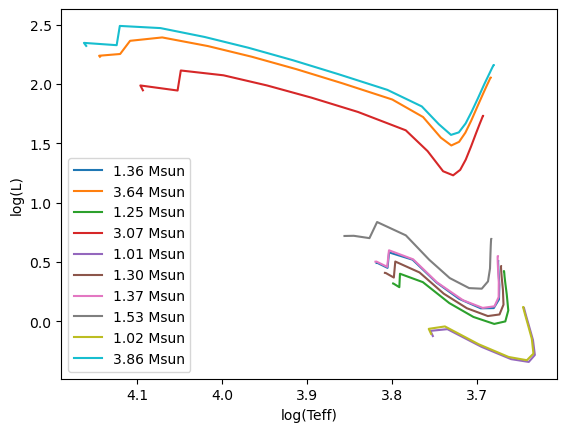

In [9]:
masses = salpeter_imf(1, 50, 10)

run_mesa_model(masses)

plot_hr_diagram(masses)